In [315]:
import data_load as dl
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Model
from keras.layers import Input, Conv2D, ZeroPadding1D, Conv2DTranspose, UpSampling2D, Dense, BatchNormalization
from keras.layers.pooling import MaxPooling2D, MaxPooling1D
from keras import optimizers
import sklearn
import tensorflow as tf


%matplotlib inline

In [351]:
path = r"C:\Users\Patrick\Datasets\sr\SR"
trial_paths = dl.combine_data(path)
trials = dl.generate_trial_objects(trial_paths)
processed_trials = dl.process_trial_data(trials)

C:\Users\Patrick\Anaconda3\lib\site-packages\openpyxl\reader\worksheet.py:318: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
#Smallest motion sample is 17559
# All G samples are 3030 long
# Take 2880 points from middle of 3030
# 3030 - 2880 = 150
#150/2 = 75
#Start each (Gs and downsampled motion on point 75) then sample out 2880

In [355]:
def synch_streams(G2, G3, G4, G5, motion):
    G2 = G2[75:-75]
    G3 = G3[75:-75]
    G4 = G4[75:-75]
    G5 = G5[75:-75]
    
    new_motion = motion[0:-1:6]
    new_motion = motion[75:(75+2880)]
    
    return G2, G3, G4, G5, new_motion

In [356]:
def generate_segments(G2, G3, G4, G5, motion):
    full_run_length = 2880
    num_segments = 400
    indices = np.random.randint(0,(full_run_length - 112), size=(num_segments))
    
    images_out = []
    motion_out = []
    
    for i in indices:
        G2_seg = G2[i:(i+112)]
        G3_seg = G3[i:(i+112)]
        G4_seg = G4[i:(i+112)]
        G5_seg = G5[i:(i+112)]
        motion_seg = motion[i:(i+112):2]
        
        new_image = np.array([[G2_seg],[G3_seg],[G4_seg],[G5_seg]])
        
        images_out.append(new_image)
        
        motion_out.append(np.asarray(motion_seg))
        
    

    return images_out, motion_out

In [361]:
X = []
y = []

for i in range(25):
    trial = processed_trials[i]
    G2_temp, G3_temp, G4_temp, G5_temp, motion_temp = synch_streams(trial.G2_AVG, trial.G3_AVG, trial.G4_AVG, trial.G5_AVG, trial.Motion_Conv)
    images, motion = generate_segments(G2_temp, G3_temp, G4_temp, G5_temp, motion_temp)
    
    for image in images:
        new_image=np.array(image)
        new_image.reshape(1,112,4)
        X.append(new_image)
    
    for entry in motion:
        y.append(np.array(entry))
        
X = np.array(X).reshape(10000,1,112,4)
y = np.array(y)

In [288]:
# trial = processed_trials[5]
# G3_temp, G4_temp, motion_temp = synch_streams(trial.G3_AVG, trial.G4_AVG, trial.Motion_Conv)
# images, motion = generate_segments(G3_temp, G4_temp, motion_temp)

# X = []
# y = []

# for image in images:
#     new_image=np.array(image)
#     new_image.reshape(1,112,2)
#     X.append(new_image)
    
# for entry in motion:
#     y.append(np.array(entry))
    


In [359]:
X.shape

(10000, 1, 112, 4)

In [360]:
y.shape

(10000, 56)

In [362]:
#X = np.expand_dims(X, axis=2)
#X = np.expand_dims(X, axis=3)

y = np.expand_dims(y, axis=1)
y.reshape(10000,1,56)
y = np.expand_dims(y, axis=3)

In [363]:
X.shape

(10000, 1, 112, 4)

In [364]:
y.shape

(10000, 1, 56, 1)

In [370]:
X = X/(np.max(abs(X)))

In [294]:
# model = Sequential()
# model.add(Conv2D(64, (2,2), padding='same', activation='relu', input_shape=(100,1,2)))
# #model.add(MaxPooling2D(2))

# # model.add(Conv2D(24, (2,2), padding='same', activation='relu'))
# # model.add(MaxPooling2D(1,2))

# # model.add(Conv2DTranspose(1, (1,1), strides=(1,1), activation='relu'))
# # model.add(UpSampling2D(size=(1,2)))

# #model.add(Conv2DTranspose(1, (1,1), strides=(1,1), activation='relu'))
# #model.add(UpSampling2D(size=(2,1)))


# model.compile(optimizer='adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [312]:
# inputs = Input(shape=(1,112,2), name="main_input")

# x1 = Conv2D(64, kernel_size=(1,3), padding="same")(inputs)
# x1 = Conv2D(64, kernel_size=(1,3),padding="same")(x1)
# x1 = MaxPooling2D(pool_size=(1,2), strides=(2))(x1)

# x2 = Conv2D(128, kernel_size=(1,3),padding="same")(x1)
# x2 = Conv2D(128, kernel_size=(1,3),padding="same")(x2)
# x2 = MaxPooling2D(pool_size=(1,2), strides=(2))(x2)

# x3 = Conv2D(256, kernel_size=(1,3),padding="same")(x2)
# x3 = Conv2D(256, kernel_size=(1,3),padding="same")(x3)
# x3 = MaxPooling2D(pool_size=(1,2), strides=(2))(x3)

# x4 = Conv2D(512, kernel_size=(1,3),padding="same")(x3)
# x4 = Conv2D(512, kernel_size=(1,3),padding="same")(x4)
# x4 = MaxPooling2D(pool_size=(1,2), strides=(2))(x4)

# x5 = Conv2D(1024, kernel_size=(1,7))(x4)

# x6 = Dense(1024)(x5)

# #Presently doing unpooling in hacked way (No filtering for max value, naive upsampling)
# # https://arxiv.org/pdf/1311.2901v3.pdf
# # https://stackoverflow.com/questions/44991470/using-tensorflow-layers-in-keras

# #Need to create custom keras layer to take mask from MaxPooling2D (similar to TF's max_pool_with_argmax)
# #mask is used in unpooling layer

# x7 = Conv2DTranspose(512, kernel_size=(1,7), padding='valid')(x6)
# x7 = UpSampling2D((1,2))(x7)

# x8 = Conv2DTranspose(512, kernel_size=(1,3), padding='same')(x7)
# x8 = Conv2DTranspose(512, kernel_size=(1,3), padding='same')(x8)
# x8 = UpSampling2D((1,2))(x8)

# x9 = Conv2DTranspose(512, kernel_size=(1,3), padding='same')(x8)
# x9 = Conv2DTranspose(256, kernel_size=(1,3), padding='same')(x9)
# x9 = UpSampling2D((1,2))(x9)

# x10 = Conv2DTranspose(256, kernel_size=(1,3), padding='same')(x9)
# x10 = Conv2DTranspose(128, kernel_size=(1,3), padding='same')(x10)
# x10 = UpSampling2D((1,2))(x10)

# x11 = Conv2DTranspose(128, kernel_size=(1,3), padding='same')(x10)
# x11 = Conv2DTranspose(64, kernel_size=(1,3), padding='same')(x11)

# x11 = Conv2DTranspose(2, kernel_size=(1,3), padding='same')(x11)
# x12 = Conv2DTranspose(1, kernel_size=(1,3), padding='same')(x11)

# model2 = Model(inputs=inputs, outputs=x12)

# sgd = optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005)

# model2.compile(optimizer=sgd, loss = 'mean_squared_error', metrics = ['mse'])

In [381]:
inputs = Input(shape=(1,112,4), name="main_input")

x1 = Conv2D(8, kernel_size=(1,3), padding="same")(inputs)
x1 = MaxPooling2D(pool_size=(1,2), strides=(2))(x1)
x1 = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True)(x1)

x2 = Conv2D(16, kernel_size=(1,3),padding="same")(x1)
x2 = MaxPooling2D(pool_size=(1,2), strides=(2))(x2)
x2 = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True)(x2)

x3 = Conv2D(32, kernel_size=(1,3),padding="same")(x2)
x3 = MaxPooling2D(pool_size=(1,2), strides=(2))(x3)
x3 = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True)(x3)

x4 = Conv2D(64, kernel_size=(1,3),padding="same")(x3)
x4 = MaxPooling2D(pool_size=(1,2), strides=(2))(x4)
x4 = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True)(x4)

x5 = Conv2D(128, kernel_size=(1,7))(x4)

x6 = Dense(128)(x5)

#Presently doing unpooling in hacked way (No filtering for max value, naive upsampling)
# https://arxiv.org/pdf/1311.2901v3.pdf
# https://stackoverflow.com/questions/44991470/using-tensorflow-layers-in-keras

#Need to create custom keras layer to take mask from MaxPooling2D (similar to TF's max_pool_with_argmax)
#mask is used in unpooling layer

x7 = Conv2DTranspose(128, kernel_size=(1,7), padding='valid')(x6)
x7 = UpSampling2D((1,2))(x7)
x7 = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True)(x7)

x8 = Conv2DTranspose(64, kernel_size=(1,3), padding='same')(x7)
x8 = UpSampling2D((1,2))(x8)
x8 = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True)(x8)

x9 = Conv2DTranspose(32, kernel_size=(1,3), padding='same')(x8)
x9 = UpSampling2D((1,2))(x9)
x9 = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True)(x9)

x10 = Conv2DTranspose(16, kernel_size=(1,3), padding='same')(x9)
x10 = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True)(x10)

x11 = Conv2DTranspose(4, kernel_size=(1,3), padding='same')(x10)
x11 = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True)(x11)

x11 = Conv2DTranspose(2, kernel_size=(1,3), padding='same')(x11)
x11 = Conv2DTranspose(1, kernel_size=(1,3), padding='same')(x11)
x12 = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True)(x11)

model2 = Model(inputs=inputs, outputs=x12)

sgd = optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0005)

model2.compile(optimizer=sgd, loss = 'mean_squared_error', metrics = ['mse'])

In [382]:
for layer in model2.layers:
    print(layer.output_shape)

(None, 1, 112, 4)
(None, 1, 112, 8)
(None, 1, 56, 8)
(None, 1, 56, 8)
(None, 1, 56, 16)
(None, 1, 28, 16)
(None, 1, 28, 16)
(None, 1, 28, 32)
(None, 1, 14, 32)
(None, 1, 14, 32)
(None, 1, 14, 64)
(None, 1, 7, 64)
(None, 1, 7, 64)
(None, 1, 1, 128)
(None, 1, 1, 128)
(None, 1, 7, 128)
(None, 1, 14, 128)
(None, 1, 14, 128)
(None, 1, 14, 64)
(None, 1, 28, 64)
(None, 1, 28, 64)
(None, 1, 28, 32)
(None, 1, 56, 32)
(None, 1, 56, 32)
(None, 1, 56, 16)
(None, 1, 56, 16)
(None, 1, 56, 4)
(None, 1, 56, 4)
(None, 1, 56, 2)
(None, 1, 56, 1)
(None, 1, 56, 1)


In [383]:
X_small = X[0:100]
y_small = y[0:100]

In [384]:
model2.fit(X_small, y_small, epochs=1000)

Epoch 1/1000
100/100 [==============================] - 16s 162ms/step - loss: 1.9454 - mean_squared_error: 1.9454
Epoch 2/1000
100/100 [==============================] - 0s 2ms/step - loss: 1.1799 - mean_squared_error: 1.1799
Epoch 3/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.4185 - mean_squared_error: 0.4185
Epoch 4/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1460 - mean_squared_error: 0.1460
Epoch 5/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1987 - mean_squared_error: 0.1987
Epoch 6/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.2954 - mean_squared_error: 0.2954
Epoch 7/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.2915 - mean_squared_error: 0.2915
Epoch 8/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.2167 - mean_squared_error: 0.2167
Epoch 9/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1504 - mean_squared_err

100/100 [==============================] - 0s 2ms/step - loss: 0.1313 - mean_squared_error: 0.1313
Epoch 74/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1316 - mean_squared_error: 0.1316
Epoch 75/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1315 - mean_squared_error: 0.1315
Epoch 76/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1311 - mean_squared_error: 0.1311
Epoch 77/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1307 - mean_squared_error: 0.1307
Epoch 78/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1306 - mean_squared_error: 0.1306
Epoch 79/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1305 - mean_squared_error: 0.1305
Epoch 80/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1304 - mean_squared_error: 0.1304
Epoch 81/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1306 - mean_squared_error: 0.13

100/100 [==============================] - 0s 2ms/step - loss: 0.1193 - mean_squared_error: 0.1193
Epoch 146/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1153 - mean_squared_error: 0.1153
Epoch 147/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1130 - mean_squared_error: 0.1130
Epoch 148/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1066 - mean_squared_error: 0.1066
Epoch 149/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1072 - mean_squared_error: 0.1072
Epoch 150/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1064 - mean_squared_error: 0.1064
Epoch 151/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1212 - mean_squared_error: 0.1212
Epoch 152/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1216 - mean_squared_error: 0.1216
Epoch 153/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.1005 - mean_squared_err

Epoch 217/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 218/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0110 - mean_squared_error: 0.0110
Epoch 219/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 220/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0128 - mean_squared_error: 0.0128
Epoch 221/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 222/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 223/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 224/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0151 - mean_squared_error: 0.0151
Epoch 225/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0102 - m

100/100 [==============================] - 0s 2ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 289/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 290/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 291/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 292/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 293/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 294/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 295/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 296/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0066 - mean_squared_err

Epoch 359/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 360/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 361/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 362/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 363/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 364/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 365/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 366/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 367/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0053 - m

100/100 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 431/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 432/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 433/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 434/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 435/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 436/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 437/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 438/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0069 - mean_squared_err

Epoch 502/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 503/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 504/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 505/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 506/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 507/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 508/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 509/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 510/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0036 - m

100/100 [==============================] - 0s 2ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 574/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0132 - mean_squared_error: 0.0132
Epoch 575/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 576/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 577/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 578/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 579/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 580/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 581/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_err

100/100 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 645/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 646/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 647/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 648/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 649/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 650/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0172 - mean_squared_error: 0.0172
Epoch 651/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 652/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_err

Epoch 716/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 717/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 718/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 719/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 720/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 721/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 722/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 723/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 724/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0038 - m

100/100 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 788/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 789/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 790/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 791/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 792/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 793/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 794/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 795/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_squared_err

Epoch 859/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 860/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 861/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 862/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 863/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 864/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 865/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 866/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 867/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0053 - m

100/100 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 931/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 932/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 933/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 934/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 935/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 936/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 937/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 938/1000
100/100 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_err

In [426]:
testno = 99
testX = np.expand_dims(X[testno],0)
testy = np.squeeze(y[testno])

In [427]:
y_pred = model2.predict(testX)
p = np.squeeze(y_pred)

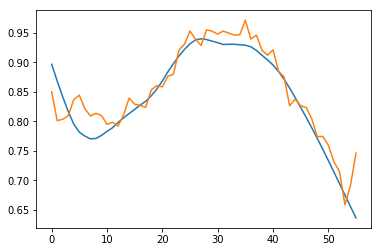

In [428]:
plt.figure()
plt.plot(testy)
plt.plot(p)